Tianyou Xiao (tx43), Ziyu Song (zs363)

CS 5785 HW 2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import string
import random
import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('punkt')
import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.svm import SVC, LinearSVC

from collections import defaultdict

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
url_train = 'https://raw.githubusercontent.com/dzuhyoosg/Applied-Machine-Learning/master/homework2/nlp-getting-started/train.csv'
url_test = 'https://raw.githubusercontent.com/dzuhyoosg/Applied-Machine-Learning/master/homework2/nlp-getting-started/test.csv'

train = pd.read_csv(url_train)
test = pd.read_csv(url_test)

In [ ]:
print(train.shape)
print(test.shape)
train.head()

(7613, 5)
(3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train.target.value_counts() # denotes whether a tweet is about a real disaster (1) or not (0)

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
df = pd.concat([train, test])
print(df.shape)

(10876, 5)


### (c) Preprocess the Data 
FYI: I switched the order of (b) and (c)

In [ ]:
# source: https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove#Data-Cleaning
# remove urls
def remove_URL(text):
  url = re.compile(r'https?://\S+|www\.\S+')
  return url.sub(r'', text)

# remove HTML tags
def remove_html(text): 
  html = re.compile(r'<.*?>')
  return html.sub(r'', text)

# remove punctuations
def remove_punct(text): 
  punct = str.maketrans('','',string.punctuation)
  return text.translate(punct)

# remove emojis
# reference: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)

df['text'] = df['text'].str.lower() # convert words to lowercase
df['text'] = df['text'].apply(lambda x : remove_URL(x))
df['text'] = df['text'].apply(lambda x : remove_html(x))
df['text'] = df['text'].apply(lambda x : remove_punct(x))
df['text'] = df['text'].apply(lambda x : remove_emoji(x))

In [ ]:
# tokenization
df['text'] = df['text'].apply(lambda x : word_tokenize(x))

# lemmatizing
def lemmatizing(words): 
  lemmatizer = WordNetLemmatizer()
  return [lemmatizer.lemmatize(word) for word in words]

df['text'] = df['text'].apply(lambda x : lemmatizing(x))

def final_text(words): 
  return ' '.join(words)

df['text'] = df['text'].apply(lambda x : final_text(x))

In [ ]:
print(df)

         id keyword  ...                                               text target
0         1     NaN  ...  our deed are the reason of this earthquake may...    1.0
1         4     NaN  ...              forest fire near la ronge sask canada    1.0
2         5     NaN  ...  all resident asked to shelter in place are bei...    1.0
3         6     NaN  ...  13000 people receive wildfire evacuation order...    1.0
4         7     NaN  ...  just got sent this photo from ruby alaska a sm...    1.0
...     ...     ...  ...                                                ...    ...
3258  10861     NaN  ...  earthquake safety los angeles ûò safety faste...    NaN
3259  10865     NaN  ...  storm in ri worse than last hurricane my citya...    NaN
3260  10868     NaN  ...                   green line derailment in chicago    NaN
3261  10874     NaN  ...            meg issue hazardous weather outlook hwo    NaN
3262  10875     NaN  ...  cityofcalgary ha activated it municipal emerge...    NaN

[10

In [ ]:
# (b)
X_train, X_test, y_train, y_test = train_test_split(df[:train.shape[0]], df[:train.shape[0]]['target'].values, test_size = 0.3, random_state=42)
print("Shape of train: ", X_train.shape)
print("Shape of validation: ", X_test.shape)
print("length of X_train: %d, X_text: %d, y_train: %d, y_test: %d" % (len(X_train), len(X_test), len(y_train), len(y_test)))

Shape of train:  (5329, 5)
Shape of validation:  (2284, 5)
length of X_train: 5329, X_text: 2284, y_train: 5329, y_test: 2284


### (e) Implement a naive Bayes classifier

FYI: I switched the order of (d) and (e)

In [ ]:
def nb_predictions(x, psis, phis):
  """
  This returns class assignments and scores under the NB model.
  We compute \arg\max_y p(y|x) as \arg\max_y p(x|y)p(y)
  """
  # adjust shapes
  n, d = x.shape
  x = np.reshape(x, (1, n, d))
  K = 2
  psis = np.reshape(psis, (K, 1, d))
  
  # clip probabilities to avoid log(0)
  psis = psis.clip(1e-14, 1-1e-14)
  
  # compute log-probabilities
  logpy = np.log(phis).reshape([K,1])
  logpxy = x * np.log(psis) + (1-x) * np.log(1-psis)
  logpyx = logpxy.sum(axis=2) + logpy

  return logpyx.argmax(axis=0).flatten(), logpyx.reshape([K,n])

### (d) Bag of Words Model (BoW)

In [ ]:
# (d) Bag of Words Model (BoW)
for i in range(1, 7): 
  print("min_df =", i)
  vectorizer = CountVectorizer(binary=True, min_df=i)
  features_train = vectorizer.fit_transform(X_train['text']).toarray()
  features_test = vectorizer.transform(X_test['text']).toarray()
  vocab = vectorizer.get_feature_names()
  print("size of vocabulary:", len(vocab))
  # reference: code from lecture 8
  n = features_train.shape[0] # size of the dataset
  d = features_train.shape[1] # number of features in our dataset
  K = 2 # number of clases

  # these are the shapes of the parameters
  psis = np.zeros([K,d])
  phis = np.zeros([K])

  # we now compute the parameters
  for k in range(K): 
    X_k = features_train[y_train == k]
    psis[k] = np.mean(X_k, axis=0)
    phis[k] = X_k.shape[0] / float(n)

  y_pred_train, logpyx_train = nb_predictions(features_train, psis, phis)
  # F1-score on train
  f1_train = f1_score(y_train, y_pred_train)
  print("f1 score on train set: %f " % f1_train)

  y_pred_test, logpyx__test = nb_predictions(features_test, psis, phis)
  # F1-score on test
  f1_test = f1_score(y_test, y_pred_test)
  print("f1 score on test set: %f " % f1_test)

min_df = 1
size of vocabulary: 13187
f1 score on train set: 0.965954 
f1 score on test set: 0.711230 
min_df = 2
size of vocabulary: 4754
f1 score on train set: 0.866621 
f1 score on test set: 0.729270 
min_df = 3
size of vocabulary: 3197
f1 score on train set: 0.832793 
f1 score on test set: 0.747778 
min_df = 4
size of vocabulary: 2476
f1 score on train set: 0.819824 
f1 score on test set: 0.749443 
min_df = 5
size of vocabulary: 2040
f1 score on train set: 0.809249 
f1 score on test set: 0.747913 
min_df = 6
size of vocabulary: 1753
f1 score on train set: 0.802601 
f1 score on test set: 0.743719 


### (f) Logistic regression prediction

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(features_train, y_train)
y_predicted_counts = clf.predict(features_test)

f1_lr = f1_score(y_test, y_predicted_counts)
print("F1 score of lr on test: %f " % f1_lr)

F1 score of lr on test: 0.756816 


In [ ]:
# inspect coefficient
clf.coef_[0]

array([0.35320103, 0.0510567 , 0.04789272, ..., 0.09281416, 1.00488798,
       0.08105375])

In [ ]:
# 10 most "important" keywords
words_sort = np.argsort(np.abs(clf.coef_[0]))
for i in np.flip(words_sort[-10:]): 
  print(vocab[i])

hiroshima
wildfire
derailment
earthquake
drought
tornado
sinkhole
spill
murder
massacre


### (g) Linear SVM prediction

In [ ]:
c_val = [0.01, 0.1, 1, 10.0, 100.0]
f1_scores = []

for c in c_val: 
  # clf_svm = SVC(C=c, kernel='linear', class_weight='balanced') # this optimizes the dual
  clf_svm = LinearSVC(C=c) # this optimizes for the primal
  clf_svm.fit(features_train, y_train)
  y_predicted = clf_svm.predict(features_test)
  f1_lsvm = f1_score(y_test, y_predicted)
  f1_scores.append(f1_lsvm)
  print("F1 score when c = {} is {} ".format(c, f1_lsvm))

F1 score when c = 0.01 is 0.7439165701042875 
F1 score when c = 0.1 is 0.7536865101037684 
F1 score when c = 1 is 0.7286012526096033 
F1 score when c = 10.0 is 0.6937531742001016 
F1 score when c = 100.0 is 0.6686686686686687 


In [ ]:
clf_svm = LinearSVC(C=0.1) # this optimizes for the primal
clf_svm.fit(features_train, y_train)

words_sort_svm = np.argsort(np.abs(clf_svm.coef_[0]))
for i in np.flip(words_sort_svm[-10:]): 
  print(vocab[i])

hiroshima
earthquake
wildfire
derailment
drought
tornado
sinkhole
murder
massacre
catastrophic


Text(0.5, 1.0, 'F1 score vs C value')

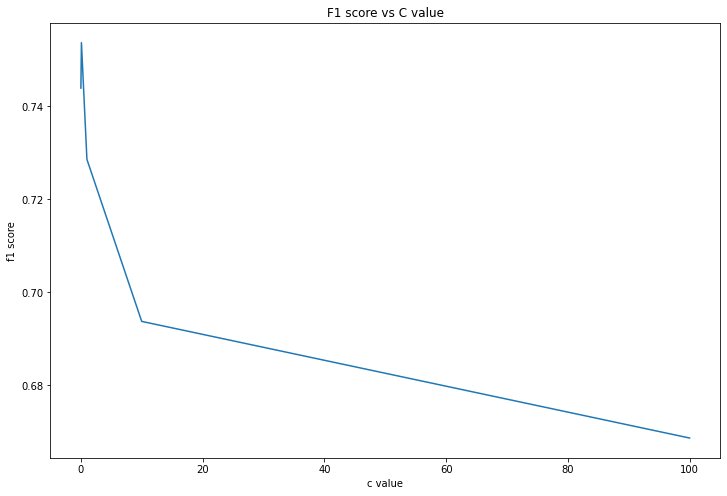

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(c_val, f1_scores)
plt.xlabel('c value')
plt.ylabel('f1 score')
plt.title('F1 score vs C value')

### (h) Non-linear SVM prediction

F1 score when c = 0.01 is 0.0 
F1 score when c = 0.1 is 0.49180327868852464 
F1 score when c = 1 is 0.745486313337216 
F1 score when c = 10.0 is 0.7413509060955518 
F1 score when c = 100.0 is 0.71875 


Text(0.5, 1.0, 'F1 score vs C value')

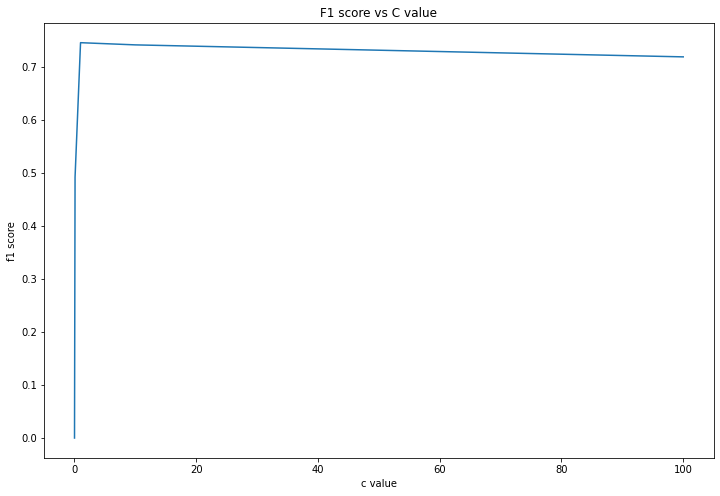

In [ ]:
f1_scores_nl = []

for c in c_val: 
  clf_nsvm = SVC(C=c, kernel='rbf') # this optimizes the dual
  clf_nsvm.fit(features_train, y_train)
  y_predicted = clf_nsvm.predict(features_test)
  f1_nlsp = f1_score(y_test, y_predicted) 
  f1_scores_nl.append(f1_nlsp)
  print("F1 score when c = {} is {} ".format(c, f1_nlsp))

plt.figure(figsize=(12, 8))
plt.plot(c_val, f1_scores_nl)
plt.xlabel('c value')
plt.ylabel('f1 score')
plt.title('F1 score vs C value')

### (i) N-gram model

In [ ]:
vectorizer_ngram = CountVectorizer(binary=True, ngram_range=(1,2), min_df=4) 
features_train_ngram = vectorizer_ngram.fit_transform(X_train['text']).toarray()
features_test_ngram = vectorizer_ngram.transform(X_test['text']).toarray()

vocab_ngram = vectorizer_ngram.get_feature_names()
one_gram_idx, two_gram_idx = [], []
for i in range(len(vocab_ngram)):
    if len(vocab_ngram[i].split()) == 1:
        one_gram_idx.append(i)
    elif len(vocab_ngram[i].split()) == 2:
        two_gram_idx.append(i)
    else:
        print(voc.split())
print(len(one_gram_idx), len(two_gram_idx), len(vocab_ngram))

2476 2125 4601


In [ ]:
[vocab_ngram[i] for i in random.sample(two_gram_idx, 10)]

['question is',
 'offensive ûª',
 'it the',
 'from dannyonpc',
 'im sorry',
 'ie madinah',
 'is hard',
 'the effect',
 'failure resulted',
 'all in']

In [ ]:
# repeat (e)
n_ngram = features_train_ngram.shape[0] # size of the dataset
d_ngram = features_train_ngram.shape[1] # number of features in our dataset
K = 2 # number of clases

# these are the shapes of the parameters
psis_ngram = np.zeros([K, d_ngram])
phis_ngram = np.zeros([K])

# we now compute the parameters
for k in range(K): 
  X_k = features_train_ngram[y_train == k]
  psis_ngram[k] = np.mean(X_k, axis=0)
  phis_ngram[k] = X_k.shape[0] / float(n_ngram)


y_pred_train, _ = nb_predictions(features_train_ngram, psis_ngram, phis_ngram)
# F1-score
f1_ngram = f1_score(y_train, y_pred_train)
print("F1 score on train set: %f " % f1_ngram)

y_pred_ngram, _ = nb_predictions(features_test_ngram, psis_ngram, phis_ngram)
# F1-score
f1_ngram = f1_score(y_test, y_pred_ngram)
print("F1 score on test set: %f " % f1_ngram)

F1 score on train set: 0.817941 
F1 score on test set: 0.735673 


In [ ]:
# repeat (f)
clf_ngram = LogisticRegression()
clf_ngram.fit(features_train_ngram, y_train)
y_predicted_counts = clf_ngram.predict(features_test_ngram)

f1_lr = f1_score(y_test, y_predicted_counts)
print("F1 score of lr on test: %f " % f1_lr)

F1 score of lr on test: 0.753973 


In [ ]:
clf_ngram.coef_[0]

array([0.09310569, 0.20607172, 0.10177264, ..., 0.0638457 , 1.05885351,
       0.06165673])

In [ ]:
words_sort = np.argsort(np.abs(clf_ngram.coef_[0]))
for i in np.flip(words_sort[-10:]): 
  print(vocab_ngram[i])

hiroshima
wildfire
earthquake
derailment
tornado
drought
flood
killed
massacre
terrorism


In [ ]:
# repeat (g)
f1_scores_lsvm_ngram = []

for c in c_val: 
  # clf_svm = SVC(C=c, kernel='linear', class_weight='balanced') # this optimizes the dual
  clf_svm_ngram = LinearSVC(C=c) # this optimizes for the primal
  clf_svm_ngram.fit(features_train_ngram, y_train)
  y_predicted = clf_svm_ngram.predict(features_test_ngram)
  f1_lsvm = f1_score(y_test, y_predicted)
  f1_scores_lsvm_ngram.append(f1_lsvm)
  print("F1 score when c = {} is {} ".format(c, f1_lsvm))

F1 score when c = 0.01 is 0.7365339578454332 
F1 score when c = 0.1 is 0.7428571428571428 
F1 score when c = 1 is 0.7008456659619451 
F1 score when c = 10.0 is 0.6777202072538859 
F1 score when c = 100.0 is 0.653555219364599 


In [ ]:
clf_svm_ngram = LinearSVC(C=0.1) # this optimizes for the primal
clf_svm_ngram.fit(features_train_ngram, y_train)

words_sort_svm = np.argsort(np.abs(clf_svm_ngram.coef_[0]))
for i in np.flip(words_sort_svm[-10:]): 
  print(vocab_ngram[i])

hiroshima
earthquake
wildfire
derailment
drought
tornado
flood
terrorism
killed
cyclone


Text(0.5, 1.0, 'F1 score vs C value')

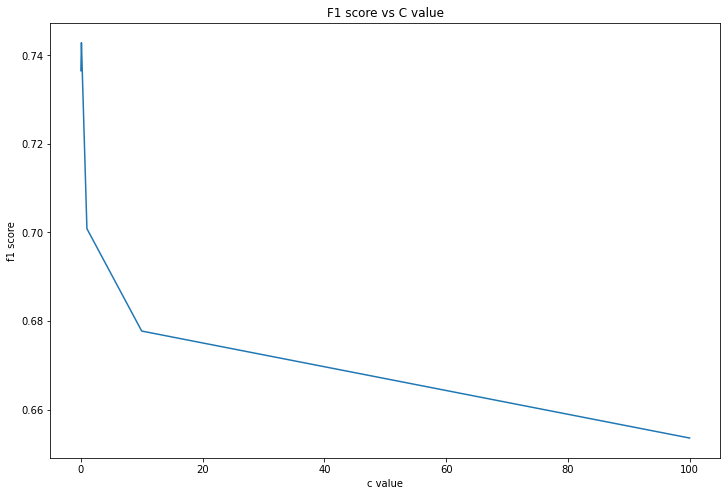

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(c_val, f1_scores_lsvm_ngram)
plt.xlabel('c value')
plt.ylabel('f1 score')
plt.title('F1 score vs C value')

F1 score when c = 0.01 is 0.0 
F1 score when c = 0.1 is 0.44356748224151527 
F1 score when c = 1 is 0.7374036751630112 
F1 score when c = 10.0 is 0.7371900826446282 
F1 score when c = 100.0 is 0.7118463180362861 


Text(0.5, 1.0, 'F1 score vs C value')

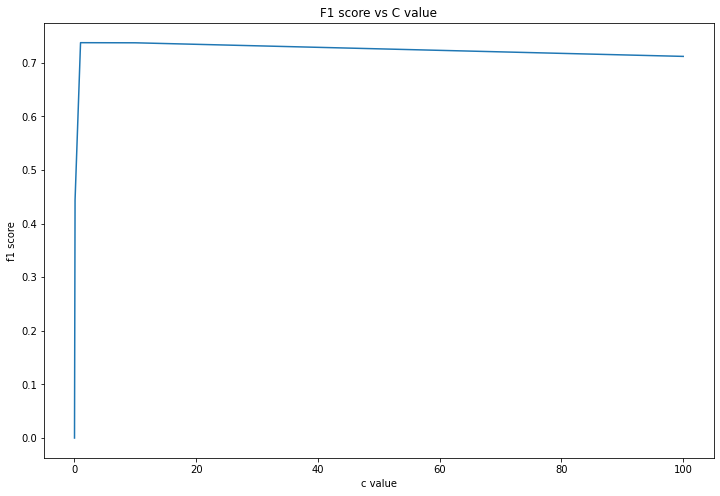

In [ ]:
# repeat (h)
f1_scores_nl_ngram = []

for c in c_val: 
  clf_nsvm_ngram = SVC(C=c, kernel='rbf') # this optimizes the dual
  clf_nsvm_ngram.fit(features_train_ngram, y_train)
  y_predicted = clf_nsvm_ngram.predict(features_test_ngram)
  f1_nlsp = f1_score(y_test, y_predicted) 
  f1_scores_nl_ngram.append(f1_nlsp)
  print("F1 score when c = {} is {} ".format(c, f1_nlsp))

plt.figure(figsize=(12, 8))
plt.plot(c_val, f1_scores_nl_ngram)
plt.xlabel('c value')
plt.ylabel('f1 score')
plt.title('F1 score vs C value')

### (j) Incorporating the additional columns

Use the BOW model

In [ ]:
X_train_additional = X_train.copy()
X_test_additional = X_test.copy()
X_train_additional['combined_tweets'] = X_train['text']

X_test_additional['combined_tweets'] = X_train['text']

combined_tweets_train, combined_tweets_test = [], []

for index, row in X_train.iterrows():
  combined_tweet = row['text']
  if not pd.isnull(row['location']):
    combined_tweet = combined_tweet + ' ' + row['location'] + ' '
  if not pd.isnull(row['location']):
    combined_tweet += row['keyword']
  combined_tweets_train.append(combined_tweet)

for index, row in X_test.iterrows():
  combined_tweet = row['text']
  if not pd.isnull(row['location']):
    combined_tweet = combined_tweet + ' ' + row['location'] + ' '
  if not pd.isnull(row['location']):
    combined_tweet += row['keyword']
  combined_tweets_test.append(combined_tweet)

X_train_additional['combined_tweets'] = combined_tweets_train
X_test_additional['combined_tweets'] = combined_tweets_test

X_train_additional['combined_tweets'] = X_train_additional['combined_tweets'].apply(lambda x : remove_punct(x))
X_test_additional['combined_tweets'] = X_test_additional['combined_tweets'].apply(lambda x : remove_punct(x))

In [ ]:
M = 5
print("min_df =", M)
vectorizer = CountVectorizer(binary=True, min_df=M)
features_train_add = vectorizer.fit_transform(X_train_additional['combined_tweets']).toarray()
features_test_add = vectorizer.transform(X_test_additional['combined_tweets']).toarray()
vocab = vectorizer.get_feature_names()
print("size of vocabulary:", len(vocab))

# reference: code from lecture 8
n = features_train_add.shape[0] # size of the dataset
d = features_train_add.shape[1] # number of features in our dataset
K = 2 # number of clases

# these are the shapes of the parameters
psis = np.zeros([K,d])
phis = np.zeros([K])

# we now compute the parameters
for k in range(K): 
  X_k = features_train_add[y_train == k]
  psis[k] = np.mean(X_k, axis=0)
  phis[k] = X_k.shape[0] / float(n)

y_pred_train, logpyx_train = nb_predictions(features_train_add, psis, phis)
# F1-score on train
f1_train = f1_score(y_train, y_pred_train)
print("f1 score on train set: %f " % f1_train)

y_pred_test, logpyx__test = nb_predictions(features_test_add, psis, phis)
# F1-score on test
f1_test = f1_score(y_test, y_pred_test)
print("f1 score on test set: %f " % f1_test)

min_df = 5
size of vocabulary: 2315
f1 score on train set: 0.814473 
f1 score on test set: 0.746814 


In [ ]:
# Logistic Regression
clf = LogisticRegression()
clf.fit(features_train_add, y_train)
y_predicted_counts = clf.predict(features_test_add)

f1_lr = f1_score(y_test, y_predicted_counts)
print("F1 score of lr on test: %f " % f1_lr)

clf.coef_[0]

words_sort = np.argsort(np.abs(clf.coef_[0]))
for i in np.flip(words_sort[-10:]): 
  print(vocab[i])

F1 score of lr on test: 0.745963 
wildfire
hiroshima
drought
derailment
earthquake
flood
ky
massacre
tornado
village


In [ ]:
# Linear SVM
f1_scores = []

for c in c_val: 
  clf_svm = LinearSVC(C=c) # this optimizes for the primal
  clf_svm.fit(features_train_add, y_train)
  y_predicted = clf_svm.predict(features_test_add)
  f1_lsvm = f1_score(y_test, y_predicted)
  f1_scores.append(f1_lsvm)
  print("F1 score when c = {} is {} ".format(c, f1_lsvm))

F1 score when c = 0.01 is 0.7425287356321839 
F1 score when c = 0.1 is 0.7462203023758099 
F1 score when c = 1 is 0.7148760330578512 
F1 score when c = 10.0 is 0.6860050890585242 
F1 score when c = 100.0 is 0.6741116751269035 


In [ ]:
clf_svm = LinearSVC(C=0.1) # this optimizes for the primal
clf_svm.fit(features_train_add, y_train)

words_sort_svm = np.argsort(np.abs(clf_svm.coef_[0]))
for i in np.flip(words_sort_svm[-10:]): 
  print(vocab[i])

wildfire
drought
hiroshima
earthquake
derailment
ky
flood
tornado
massacre
spill


Text(0.5, 1.0, 'F1 score vs C value')

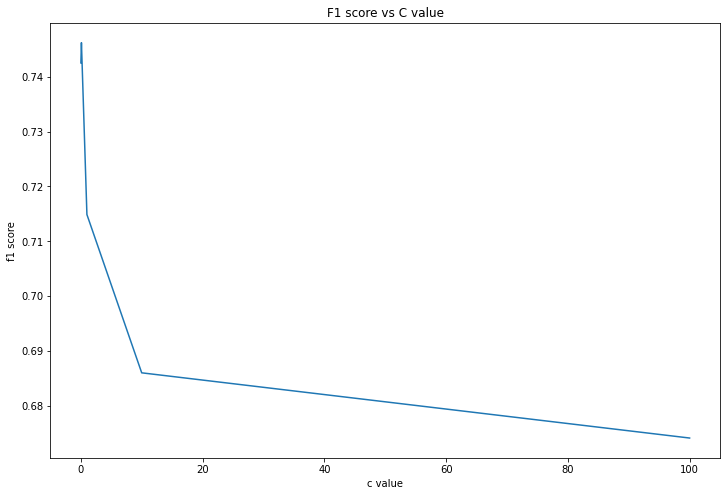

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(c_val, f1_scores)
plt.xlabel('c value')
plt.ylabel('f1 score')
plt.title('F1 score vs C value')

F1 score when c = 0.01 is 0.0 
F1 score when c = 0.1 is 0.4513137557959814 
F1 score when c = 1 is 0.7412993039443155 
F1 score when c = 10.0 is 0.7370737073707371 
F1 score when c = 100.0 is 0.7218614718614718 


Text(0.5, 1.0, 'F1 score vs C value')

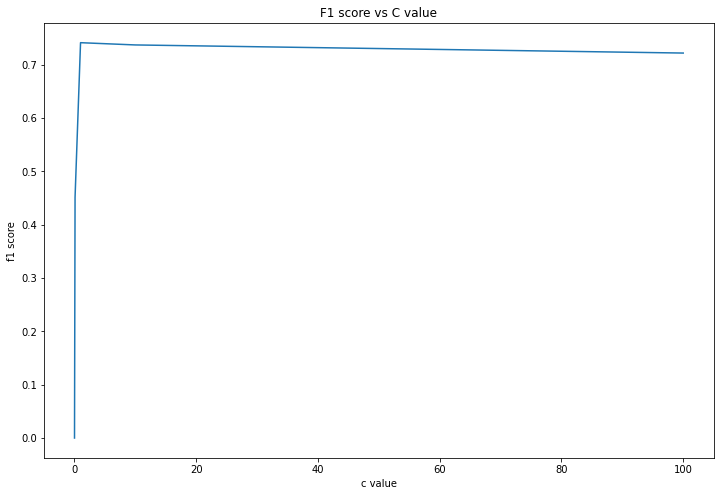

In [ ]:
# Non-linear SVM
f1_scores_nl = []

for c in c_val: 
  clf_nsvm = SVC(C=c, kernel='rbf') # this optimizes the dual
  clf_nsvm.fit(features_train_add, y_train)
  y_predicted = clf_nsvm.predict(features_test_add)
  f1_nlsp = f1_score(y_test, y_predicted) 
  f1_scores_nl.append(f1_nlsp)
  print("F1 score when c = {} is {} ".format(c, f1_nlsp))

plt.figure(figsize=(12, 8))
plt.plot(c_val, f1_scores_nl)
plt.xlabel('c value')
plt.ylabel('f1 score')
plt.title('F1 score vs C value')

### (k) finalizing your model

In [ ]:
# choose logistic regression with min_df=4
vectorizer = CountVectorizer(binary=True, min_df=4)
features_train = vectorizer.fit_transform(train['text']).toarray()
features_test = vectorizer.transform(test['text']).toarray()
vocab = vectorizer.get_feature_names()
print("size of vocabulary:", len(vocab))

clf = LogisticRegression()
clf.fit(features_train, train['target'].values)
y_predicted = clf.predict(features_test)

size of vocabulary: 3423


In [ ]:
# submission for logistic regression
submission = pd.DataFrame(y_predicted, columns=['target'])
submission['id'] = test['id']
submission.set_index(submission['id'], inplace=True, drop=True)
submission = submission.drop(['id'], axis=1)

In [ ]:
submission.to_csv('submission.csv')

In [ ]:
# submission for nonlinear SVM with RBF

clf_nsvm = SVC(C=1, kernel='rbf') # this optimizes the dual
clf_nsvm.fit(features_train, train['target'].values)
y_predicted = clf_nsvm.predict(features_test)

submission = pd.DataFrame(y_predicted, columns=['target'])
submission['id'] = test['id']
submission.set_index(submission['id'], inplace=True, drop=True)
submission = submission.drop(['id'], axis=1)

In [ ]:
submission.to_csv('submission.csv')